# AHRS Filter/Fusion Viewer

## Load raw sensor data
To view different data, change the path in "data_source" to a folder containing your data. Refer to the CSV files within the "sample_data" folder for expected format.


The "XX_SCALE" constants below are for scalar multiplication of the data. The resultant scaling should leave the accelerometer data in g's, the gyroscope data in rad/s, and the magnetometer data in uT. The "CORRECTION_VEC" is a vector which is added to each data point to apply correction values to the data (this is especially important with the gyroscope data). These values should be adjusted per sensor (tests with the same sensor should use the same corrections).

In [1]:
%matplotlib notebook
%reload_ext autoreload
%autoreload
import os
import numpy as np
import math
import quaternion_math
import fusion_6_axis
import plot_handler
import matplotlib.pyplot as plt
import ipywidgets as widgets

data_source = "./sample_data"
NUM_HEADER_LINES = 4 # number of header lines in the file
TIME_INDEX = 0
ACCEL_INDEX = 1
GYRO_INDEX = 4
MAGN_INDEX = 7

TIME_SCALE = 0.000000001 # nanoseconds to seconds
ACCEL_SCALE = 1.0
GYRO_SCALE = 0.01745329251994329576923690768489 # degrees to radians
MAGN_SCALE = 1.0

CORRECTION_VEC = np.array([
    0,
    0.0, 0.0, 0.0, # accelerometer x,y,z corrections
    -0.035, -0.018, -0.015, # gyro x,y,z corrections
    0.0, 0.0, 0.0 # magnetometer x,y,z corrections
])

SCALE_VEC = np.array([
    TIME_SCALE,
    ACCEL_SCALE, ACCEL_SCALE, ACCEL_SCALE,
    GYRO_SCALE, GYRO_SCALE, GYRO_SCALE,
    MAGN_SCALE, MAGN_SCALE, MAGN_SCALE
])


raw_9_axis = {} # dictionary to hold our data sets / file names


# Loop through our files to parse data
for root, dirs, files in os.walk(data_source, topdown=False):
    for name in files:
        # Fill in our array
        unscaled_data = np.genfromtxt(os.path.join(root, name), delimiter=',', dtype='f4', 
                                          skip_header=NUM_HEADER_LINES, encoding='ascii')
        scaled_data = np.multiply(unscaled_data, SCALE_VEC[None, :])
        raw_9_axis[name] = np.add(scaled_data, CORRECTION_VEC[None, :])

## Filter & fuse the raw data

The "BETA" and "ZETA" constants below are adjustable values in the Madgwick Filter/Fusion scheme. Refer to the [original report](https://x-io.co.uk/res/doc/madgwick_internal_report.pdf) for more information. "NUM_FUSION_ITERATIONS" determines how many times the algorithm will run on each data point before moving on to the next.

In [2]:
BETA = 0.041
ZETA = 0.0

NUM_FUSION_ITERATIONS = 1

QUAT_INDEX = 1
TAIT_BRYAN_INDEX = 5

fused_6_axis = {}
for key, value in raw_9_axis.items():
    fused_6_axis[key] = np.empty((len(value), 8))
   
    # Get initial orientation
    quat = quaternion_math.quat_from_accel(value[0][ACCEL_INDEX:(ACCEL_INDEX + 3)])
    tait_bryan = quaternion_math.quat_to_tait_bryan(quat)
    time_prev = value[0][TIME_INDEX]
    
    fused_6_axis[key][0, TIME_INDEX] = time_prev
    fused_6_axis[key][0, QUAT_INDEX:QUAT_INDEX + 4] = quat
    fused_6_axis[key][0, TAIT_BRYAN_INDEX:TAIT_BRYAN_INDEX + 3] = tait_bryan
    
    # Fuse the rest of the data set
    for i in range(1, len(value)):
        delta_t = value[i][TIME_INDEX] - time_prev
        time_prev = value[i][TIME_INDEX]
        
        # Iterate fusion n times for each data point
        for _ in range(NUM_FUSION_ITERATIONS):
            quat = fusion_6_axis.madgwick_update_6(
                quat, 
                value[i][ACCEL_INDEX:(ACCEL_INDEX + 3)], 
                value[i][GYRO_INDEX:(GYRO_INDEX + 3)], 
                delta_t, 
                BETA, 
                ZETA,
            )
            
        tait_bryan = quaternion_math.quat_to_tait_bryan(quat)
        fused_6_axis[key][i, TIME_INDEX] = time_prev
        fused_6_axis[key][i, QUAT_INDEX:QUAT_INDEX + 4] = quat
        fused_6_axis[key][i, TAIT_BRYAN_INDEX:TAIT_BRYAN_INDEX + 3] = tait_bryan


## Plotting the data

<IPython.core.display.Javascript object>


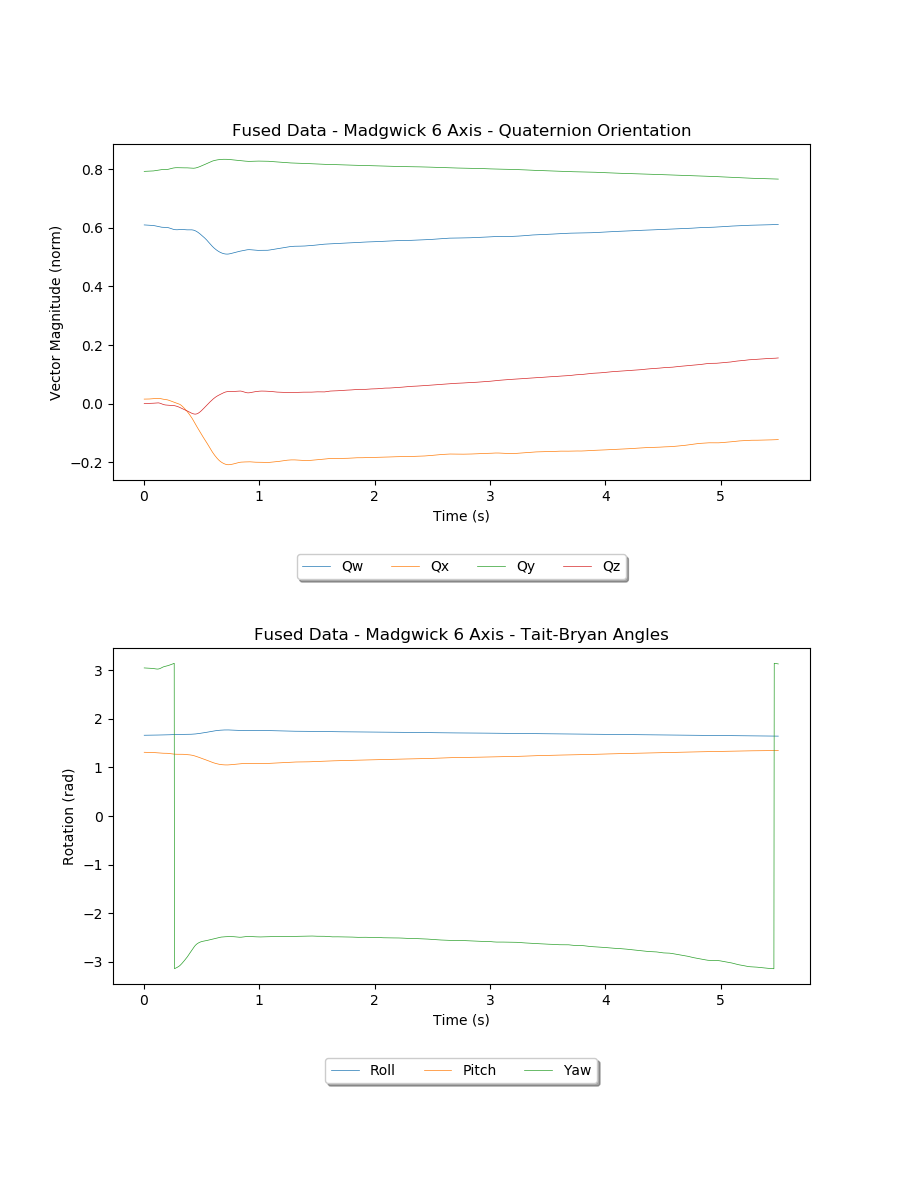

In [5]:
# Setup figure
plt.rcParams['figure.figsize'] = [9, 12]
plt.rcParams['lines.linewidth'] = 0.5
fig = plt.figure()

def plot_accel(file_name):
    plot_handler.plot_raw_data_type(fig, raw_9_axis, file_name, TIME_INDEX, ACCEL_INDEX, 
                                    "Accelerometer Measurements", "Acceleration (g)")
    
def plot_gyro(file_name):
    plot_handler.plot_raw_data_type(fig, raw_9_axis, file_name, TIME_INDEX, GYRO_INDEX, 
                                    "Gyroscope Measurements", "Rate of Rotation (rad/s)")
    
def plot_magn(file_name):
    plot_handler.plot_raw_data_type(fig, raw_9_axis, file_name, TIME_INDEX, MAGN_INDEX,
                                    "Magnetometer Measurements", "Magnetic Field Strength (uT)")
    
def plot_madgwick_6(file_name):
    plot_handler.plot_filtered_data(fig, fused_6_axis, file_name, TIME_INDEX, QUAT_INDEX,
                                    TAIT_BRYAN_INDEX, "Fused Data - Madgwick 6 Axis")

plot_types = {
    'Accelerometer': plot_accel,
    'Gyroscope': plot_gyro,
    'Magnetometer': plot_magn,
    'Madgwick 6 Axis': plot_madgwick_6,
}

def update_plots(_):
    # Call the plot function associated with the data type
    plot_types[plot_type_select.value](file_name_select.value)

# Configure selection boxes
plot_type_select = widgets.Select(
    options = plot_types.keys(),
    description = 'Plot type',
    disabled = False,
    layout = widgets.Layout(width = "300px")           
)
file_name_select = widgets.Select(
    options= raw_9_axis.keys(),
    description='Data sets',
    disabled = False,
    layout = widgets.Layout(width = "300px")
)

# Update plots button
update_plots_btn = widgets.Button(
    description="Update plots",
    disabled = False,
    layout = widgets.Layout(margin = "10px 0 20px 90px", border = "1px solid gray")
)  
update_plots_btn.on_click(update_plots)

# Display our widgets
widgets.VBox([update_plots_btn, widgets.HBox([plot_type_select, file_name_select])])